# PBN that use both the original model and the derived KG model


Sensitivity analysis of the PBN


In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import itertools
import pickle
# import booleanNetwork module from ./src
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix  
from BNMPy import PBN

## Merge the two models to a PBN
### The original model

Vundavilli 2020 Model from the paper: DOI: 10.1109/TCBB.2018.2872573 (link: https://www.ncbi.nlm.nih.gov/pubmed/30281473)

In [2]:
with open('input_files/Vundavilli2020_standardized.txt', 'r') as f:
    original_string = f.read()
print(original_string)
network = BMatrix.load_network_from_string(original_string)

EGF = EGF
HBEGF = HBEGF
IGF1 = IGF1
NRG1 = NRG1
PTEN = PTEN
STK11 = STK11
EGFR = EGF
ERBB4 = HBEGF | EGF
IGF1R = IGF1
ERBB2 = NRG1
JAK1 = EGFR
STAT3 = JAK1
IRS1 = IGF1R
GRB2 = (ERBB2 | IGF1R) | (ERBB4 | EGFR)
KRAS = GRB2
MAP3K1 = KRAS
RAF1 = KRAS
MAP2K4 = MAP3K1
MAP2K1 = RAF1
PIK3CA = (ERBB2 | IRS1) | (KRAS | STAT3)
MAPK8 = MAP2K4
MAPK3 = MAP2K1
PIP3 = ! PTEN | PIK3CA
PDPK1 = PIP3
AKT1 = PIP3
PRKAA1 = STK11
GSK3B = ! AKT1
TSC1 = PRKAA1 | ( ! AKT1)
RHEB = ! TSC1
MTOR = RHEB
RPS6KB1 = MTOR | (PDPK1 | MAPK3)
BAD = ! (AKT1 | RPS6KB1)
CCND1 = ! GSK3B
BCL2 = ( ! BAD & STAT3)
ELK1 = RPS6KB1 & MAPK3
FOS = RPS6KB1 & MAPK8
ELK4 = RPS6KB1 & MAPK3
SP1 = MAPK3


No initial state provided, using a random initial state


### The derived KG model

See `knowledge_graph.ipynb` for more details.

In [3]:
from BNMPy import build_bn_from_kg
genes = network.nodeDict.keys()
KG_string, relations = build_bn_from_kg.load_signor_network(genes, joiner='inhibitor_wins')
print(KG_string)

number of genes found: 37
[1950, 1839, 3479, 3084, 5728, 6794, 1956, 2066, 3480, 2064, 3716, 6774, 3667, 2885, 3845, 4214, 5894, 6416, 5604, 5290, 5599, 5595, 5170, 207, 5562, 2932, 7248, 6008, 2475, 6198, 572, 595, 596, 2002, 2353, 2005, 5669]
STAT3 = MAPK8 | MAPK3 | MTOR | JAK1 | EGFR | MAP3K1
CCND1 = (!GSK3B) & (STAT3)
GSK3B = (!MAPK3 & !AKT1 & !STK11) & (GSK3B | MAP2K1)
RPS6KB1 = MAPK3 | MTOR | PDPK1
MAPK8 = (!RPS6KB1) & (MAP2K4 | (-)-anisomycin)
BAD = !MAPK8 & !MAPK3 & !AKT1 & !RAF1
FOS = MAPK3 | (-)-anisomycin
MAPK3 = MAPK3 | MAP2K1
MTOR = (!RPS6KB1 & !TSC1) & (MTOR | AKT1 | PIK3CA)
AKT1 = (!PTEN) & (MAPK8 | MTOR | PDPK1 | PIK3CA | IGF1R)
JAK1 = EGFR
ERBB4 = ERBB2 | NRG1 | HBEGF
EGFR = (!MAPK3) & (EGFR | ERBB2 | EGF | HBEGF)
PDPK1 = IGF1R
PTEN = (!GSK3B) & (PTEN)
ERBB2 = EGFR | ERBB2 | NRG1 | EGF
PIK3CA = (!PTEN) & (ERBB4 | IRS1 | KRAS)
IGF1R = IGF1R | IGF1
IRS1 = (!RPS6KB1 & !MAPK8 & !MAPK3 & !MTOR & !PIK3CA & !MAP2K1) & (JAK1 | IGF1R)
ELK1 = MAPK8 | MAPK3
BCL2 = (!BAD) & (MAPK8

In [7]:
KG_string = KG_string.replace('(-)-anisomycin', 'anisomycin')

### Merge the two models to a PBN

In [8]:
def merge_PBN_string(original_string, KG_string, prob=0.5):
    """
    Merge the original model and the KG model to a PBN
    prob: probability of the equations from the original model
    """
    # Parse equations from both models
    original_equations = {}
    for line in original_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            original_equations[target.strip()] = rule.strip()
    
    kg_equations = {}
    for line in KG_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            kg_equations[target.strip()] = rule.strip()
    
    # Merge equations
    merged_equations = []
    all_targets = set(original_equations.keys()) | set(kg_equations.keys())
    
    for target in all_targets:
        if target in original_equations and target in kg_equations:
            if original_equations[target] == kg_equations[target]:
                # Both models have the same equation for this target
                merged_equations.append(f"{target} = {original_equations[target]}, 1")
            else:
                # Use both with specified probabilities
                merged_equations.append(f"{target} = {original_equations[target]}, {prob}")
                merged_equations.append(f"{target} = {kg_equations[target]}, {1-prob}")
        elif target in original_equations:
            # Only original model has this target
            merged_equations.append(f"{target} = {original_equations[target]}, 1")
            print(f"Only original model has this target: {target}")
        else:
            # Only KG model has this target
            print("Only KG model has this target:", target)
            merged_equations.append(f"{target} = {kg_equations[target]}, 1")
    
    # remove equation with prob = 0
    merged_equations = [eq for eq in merged_equations if eq.split(',')[1] != ' 0']
    merged_string = '\n'.join(merged_equations)
    return merged_string

merged_string = merge_PBN_string(original_string, KG_string, prob=0.6)
print(merged_string)

Only KG model has this target: anisomycin
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
ELK1 = RPS6KB1 & MAPK3, 0.6
ELK1 = MAPK8 | MAPK3, 0.4
EGF = EGF, 1
BAD = ! (AKT1 | RPS6KB1), 0.6
BAD = !MAPK8 & !MAPK3 & !AKT1 & !RAF1, 0.4
MAP2K1 = RAF1, 0.6
MAP2K1 = PDPK1 | MAP2K1 | MAP3K1 | RAF1, 0.4
IGF1R = IGF1, 0.6
IGF1R = IGF1R | IGF1, 0.4
GRB2 = (ERBB2 | IGF1R) | (ERBB4 | EGFR), 0.6
GRB2 = ERBB4 | ERBB2 | IRS1, 0.4
JAK1 = EGFR, 1
PRKAA1 = STK11, 0.6
PRKAA1 = (!AKT1 & !PRKAA1) & (STK11), 0.4
CCND1 = ! GSK3B, 0.6
CCND1 = (!GSK3B) & (STAT3), 0.4
IRS1 = IGF1R, 0.6
IRS1 = (!RPS6KB1 & !MAPK8 & !MAPK3 & !MTOR & !PIK3CA & !MAP2K1) & (JAK1 | IGF1R), 0.4
ELK4 = RPS6KB1 & MAPK3, 0.6
ELK4 = PCSK7, 0.4
KRAS = GRB2, 0.6
KRAS = KRAS, 0.4
IGF1 = IGF1, 1
MTOR = RHEB, 0.6
MTOR = (!RPS6KB1 & !TSC1) & (MTOR | AKT1 | PIK3CA), 0.4
ERBB2 = NRG1, 0.6
ERBB2 = EGFR | ERBB2 | NRG1 | EGF, 0.4
ERBB4 = HBE

## Simulation setup

Calculation of the size difference between the output of the model and the ideal output is as in the paper.   
The ideal output is output_genes = [000000], which also corresponds to a lack of cell proliferation and a non-suppression of apoptosis.

In [12]:
# Dic file to specify how should the values of the genes be changed when mutated, 
# e.g. oncogene 'FLT3 = 1', TSG 'TP53 = 0'
# These genes will be set constant during the whole computation process.

mutations_dict = {'MAP2K4': 0, 'KRAS': 1}

# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {}
cell_profiles['Normal'] = ''
cell_profiles['KRAS_mutated'] = 'KRAS' # KP4
cell_profiles['MAP2K4_mutated'] = 'MAP2K4' # cell line that only has MKK4 mutation doesn't exist in GDSC
cell_profiles['KRAS_MAP2K4_mutated'] = 'KRAS,MAP2K4' # CAPAN1

drugs = ['Untreated', 'Cryptotanshinone', 'LY294002', 'Temsirolimus', 'Lapatinib', 'HO-3867']
drug_knockouts = {'Cryptotanshinone': ['STAT3', 'MAPK3'],
                  'LY294002': ['PIK3CA'],
                  'Temsirolimus': ['MTOR'], 
                  'Lapatinib': ['EGFR', 'ERBB4', 'ERBB2'],
                  'HO-3867': ['STAT3'],
                  'Untreated': []
                 }
# Combination of drugs in pairs
double_drugs = list(itertools.combinations([d for d in drugs if d != 'Untreated'], 2))
double_drug_names = [f"{d1}+{d2}" for d1, d2 in double_drugs]
all_treatments = drugs + double_drug_names

# Calculate size difference as the output of the model
df_size_differences_bi = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)

# Define a function to calculate size difference
def calculate_size_difference_bi(output_values):
    """
    Calculate the size difference metric between the actual output and ideal output (all zeros).
    
    Based on the formula d_s(a,b) = ((B+C)/(A+B+C+D))^2, where:
    - A: count of positions where both vectors have 1 (matches of 1s)
    - B: count of positions where a=0, b=1 (mismatches)
    - C: count of positions where a=1, b=0 (mismatches)
    - D: count of positions where both vectors have 0 (matches of 0s)
    
    For our case, the ideal vector b is all zeros, so:
    - A = 0 (no positions where both are 1)
    - B = 0 (no positions where actual=0, ideal=1)
    - C = sum(output_values) (counts of 1s in actual output)
    - D = len(output_values) - sum(output_values) (counts of 0s in actual output)
    
    This simplifies to: d_s(a,b) = (C/(C+D))^2 = (sum(output_values)/len(output_values))^2
    """
    total_positions = len(output_values)
    mismatches = sum(output_values)  # C: positions where actual=1, ideal=0
    
    if total_positions == 0:
        return 0.0
    else:
        proportion_mismatches = mismatches / total_positions
        return proportion_mismatches ** 2

output_genes = ['CCND1', 'BCL2', 'ELK1', 'FOS', 'ELK4', 'SP1']

def run_pbn_simulation(prob_value, noise=0.05, n_steps=100000, seed=99):
    """
    Run the full PBN simulation with a specific probability value.
    
    Args:
        prob_value: Probability for original model equations
        noise: Noise level for simulation
        n_steps: Number of simulation steps
        seed: Seed for the random number generator
    
    Returns:
        DataFrame of size differences (using all-zeros baseline)
    """
    np.random.seed(seed)
    
    # Create the merged PBN with specified probability
    merged_string = merge_PBN_string(original_string, KG_string, prob=prob_value)
    pbn = BMatrix.load_pbn_from_string(merged_string)
    
    # Initialize results dataframe
    df_results = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)
    
    # Process each cell line
    for cell_line, mutation_profile in cell_profiles.items():
        mutations = mutation_profile.split(',') if mutation_profile else []
        
        # Process each drug treatment
        for drug in drugs:
            pbn.undoKnockouts()
            pbn.setInitialValue('PTEN', 1)
            pbn.setInitialValue('STK11', 1)
            pbn.setInitialValue('EGF', 0)
            pbn.setInitialValue('HBEGF', 0)
            pbn.setInitialValue('IGF1', 0)
            pbn.setInitialValue('NRG1', 0)
            
            # Apply mutations based on cell line 
            for gene in mutations:
                if gene.strip(): 
                    pbn.knockout(gene, mutations_dict[gene])
           
            # Apply drug effects
            for ko_gene in drug_knockouts[drug]:
                pbn.knockout(ko_gene, 0)
            
            if noise == 0:
                # Run simulation
                results = pbn.update(n_steps) 
            else:
                # Run simulation
                results = pbn.update_noise(noise, n_steps) 
            cal_range = results[n_steps//2:n_steps]
            average_array = np.mean(cal_range, axis=0)
            output_values = [average_array[pbn.nodeDict[k]] for k in output_genes]
            
            # Calculate size difference against all-zeros baseline
            size_diff = calculate_size_difference_bi(output_values)
            df_results.loc[cell_line, drug] = size_diff
        
        # Process each double drug combination
        for d1, d2 in double_drugs:
            combo_name = f"{d1}+{d2}"
            
            pbn.undoKnockouts()
            pbn.setInitialValue('PTEN', 1)
            pbn.setInitialValue('STK11', 1)
            pbn.setInitialValue('EGF', 0)
            pbn.setInitialValue('HBEGF', 0)
            pbn.setInitialValue('IGF1', 0)
            pbn.setInitialValue('NRG1', 0)
            
            # Apply mutations
            for gene in mutations:
                if gene.strip():
                    pbn.knockout(gene, mutations_dict[gene])
            
            # Apply combined drug effects
            for ko_gene in drug_knockouts[d1] + drug_knockouts[d2]:
                pbn.knockout(ko_gene, 0)
            
            # Run simulation
            if noise == 0:
                pbn_traj = pbn.update(n_steps)
            else:
                pbn_traj = pbn.update_noise(noise, n_steps)
            cal_range = pbn_traj[n_steps//2:n_steps]
            average_array = np.mean(cal_range, axis=0)
            output_values = [average_array[pbn.nodeDict[k]] for k in output_genes]
            
            # Calculate size difference
            size_diff = calculate_size_difference_bi(output_values)
            df_results.loc[cell_line, combo_name] = size_diff
    
    return df_results

# Simulation 


## PBN (0.5)

Using the PBN with probability 0.5 for the original model.

In [10]:
merged_string = merge_PBN_string(original_string, KG_string, prob=0.5)
print(merged_string)
pbn = BMatrix.load_pbn_from_string(merged_string)

Only KG model has this target: anisomycin
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
ELK1 = RPS6KB1 & MAPK3, 0.5
ELK1 = MAPK8 | MAPK3, 0.5
EGF = EGF, 1
BAD = ! (AKT1 | RPS6KB1), 0.5
BAD = !MAPK8 & !MAPK3 & !AKT1 & !RAF1, 0.5
MAP2K1 = RAF1, 0.5
MAP2K1 = PDPK1 | MAP2K1 | MAP3K1 | RAF1, 0.5
IGF1R = IGF1, 0.5
IGF1R = IGF1R | IGF1, 0.5
GRB2 = (ERBB2 | IGF1R) | (ERBB4 | EGFR), 0.5
GRB2 = ERBB4 | ERBB2 | IRS1, 0.5
JAK1 = EGFR, 1
PRKAA1 = STK11, 0.5
PRKAA1 = (!AKT1 & !PRKAA1) & (STK11), 0.5
CCND1 = ! GSK3B, 0.5
CCND1 = (!GSK3B) & (STAT3), 0.5
IRS1 = IGF1R, 0.5
IRS1 = (!RPS6KB1 & !MAPK8 & !MAPK3 & !MTOR & !PIK3CA & !MAP2K1) & (JAK1 | IGF1R), 0.5
ELK4 = RPS6KB1 & MAPK3, 0.5
ELK4 = PCSK7, 0.5
KRAS = GRB2, 0.5
KRAS = KRAS, 0.5
IGF1 = IGF1, 1
MTOR = RHEB, 0.5
MTOR = (!RPS6KB1 & !TSC1) & (MTOR | AKT1 | PIK3CA), 0.5
ERBB2 = NRG1, 0.5
ERBB2 = EGFR | ERBB2 | NRG1 | EGF, 0.5
ERBB4 = HBE

## Simulation - with noise
### First, test for convergence for the PBN
Simulate 10000 steps with noise 0.05 for each cell line with no drug treatment.

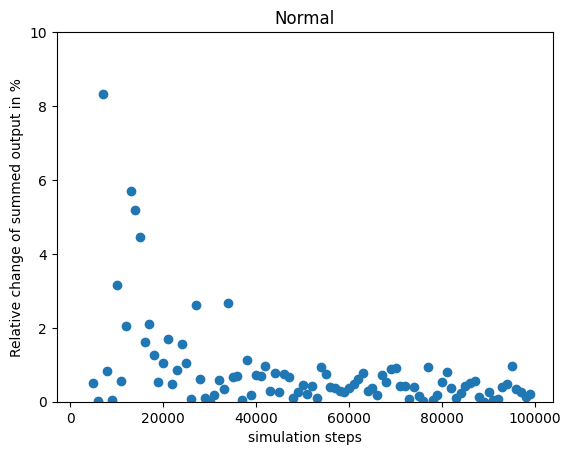

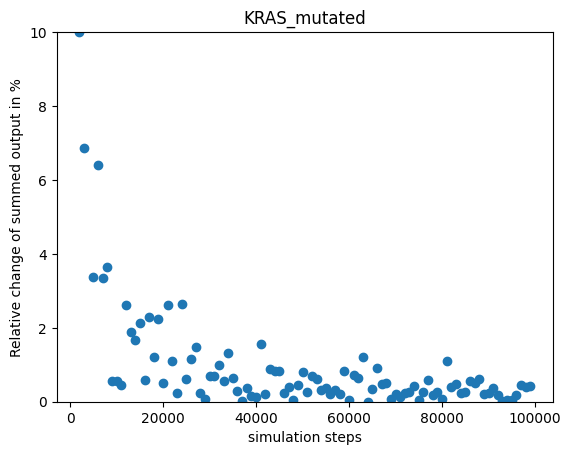

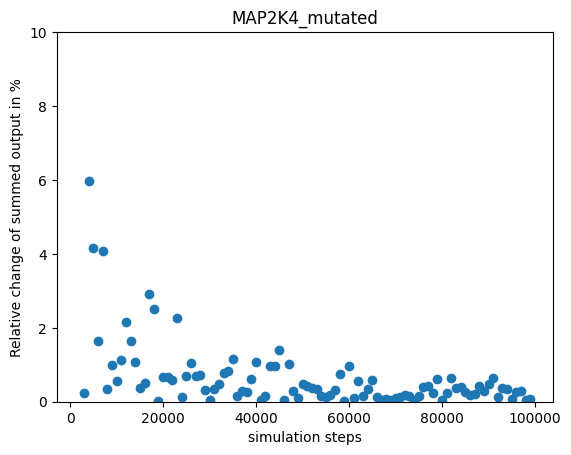

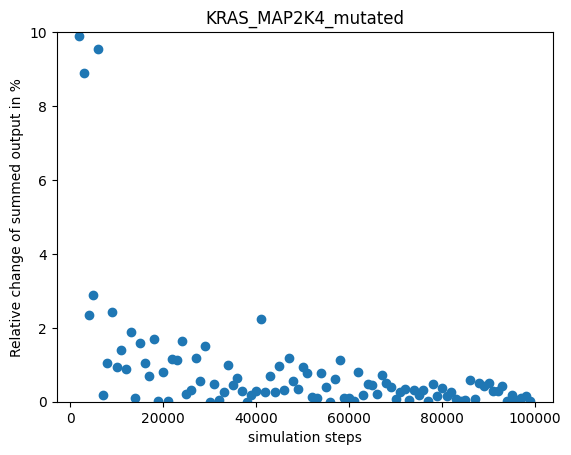

In [11]:
# Test for convergence
n = 100000
noise = 0.05
steps = list(range(1000, 100000, 1000))
scores_steps = {}
for cell_line, mutation_profile in cell_profiles.items():
    scores = []
    scores_array = []
    mutations = mutation_profile.split(',') if mutation_profile else []
    # mutations based on cell line 
    for gene in mutations:
        if gene.strip(): 
            pbn.knockout(gene, mutations_dict[gene])
    pbn.setInitialValue('PTEN', 1)
    pbn.setInitialValue('STK11', 1)
    pbn.setInitialValue('EGF', 0)
    pbn.setInitialValue('HBEGF', 0)
    pbn.setInitialValue('IGF1', 0)
    pbn.setInitialValue('NRG1', 0)

    pbn_traj = pbn.update_noise(noise, n)
    for step in steps:
        cal_range = pbn_traj[step//2:step]
        average_array = np.mean(cal_range, axis=0)
        output_values = [average_array[pbn.nodeDict[k]] for k in output_genes]
        scores_array.append(output_values) 
        scores.append(np.sum(output_values)) # take the sum of all the output values
    scores_steps.update({cell_line: scores})

for cell_line in cell_profiles:
    scores = scores_steps[cell_line]
    
    # compute the difference in scores
    rel_diff_scores = []
    for i in range(1, len(scores)):
        diff = scores[i] - scores[i - 1]
        rel_diff_scores.append(100*abs(diff))
    
    
    fig = plt.figure()
    plt.scatter(steps[1:], rel_diff_scores)
    plt.xlabel('simulation steps')
    plt.ylabel('Relative change of summed output in %')
    plt.ylim(0, 10)
    plt.title(f'{cell_line}')
    plt.show()

## test with prob = 0.5

In [13]:
df_size_differences = run_pbn_simulation(prob_value=0.5, noise=0.05, n_steps=100000)

Only KG model has this target: anisomycin
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


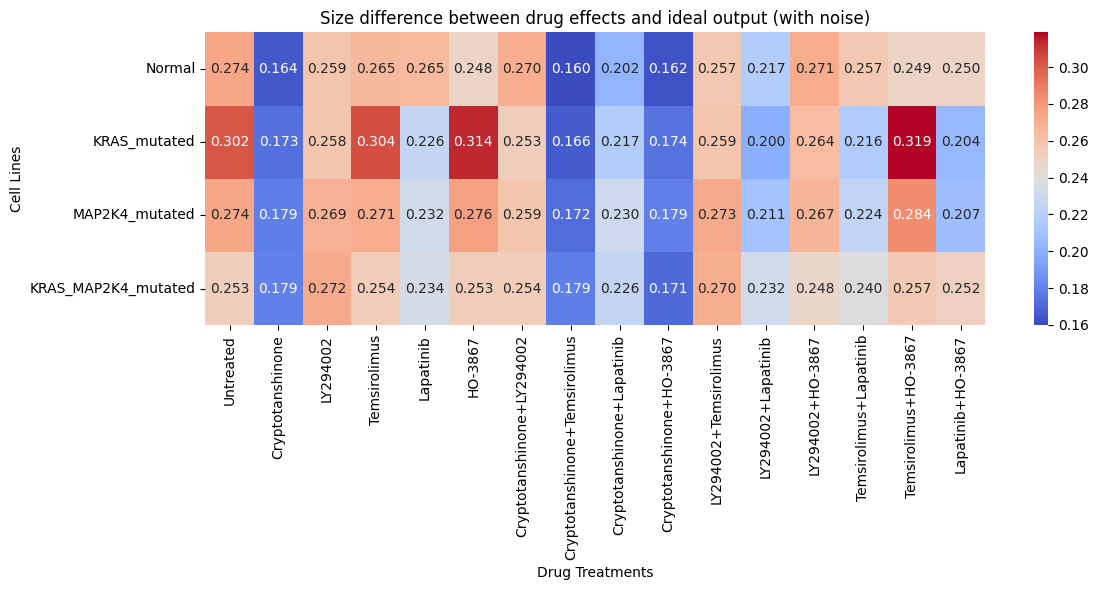

In [16]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_size_differences.astype(float), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Size difference between drug effects and ideal output (with noise)")
plt.ylabel("Cell Lines")
plt.yticks(rotation=0)
plt.xlabel("Drug Treatments")
plt.tight_layout()
plt.show()

# Interpretation of the results: 
# - Blue: size difference is 0 means that the output is the same as normal, untreated with normal apoptosis and no proliferation.
# - Red: size difference is 1 means that the output is the opposite of the ideal output with no apoptosis and high proliferation.

# Sensitivity analysis
## with no noise, steps = 1000

Running simulation with probability = 0
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


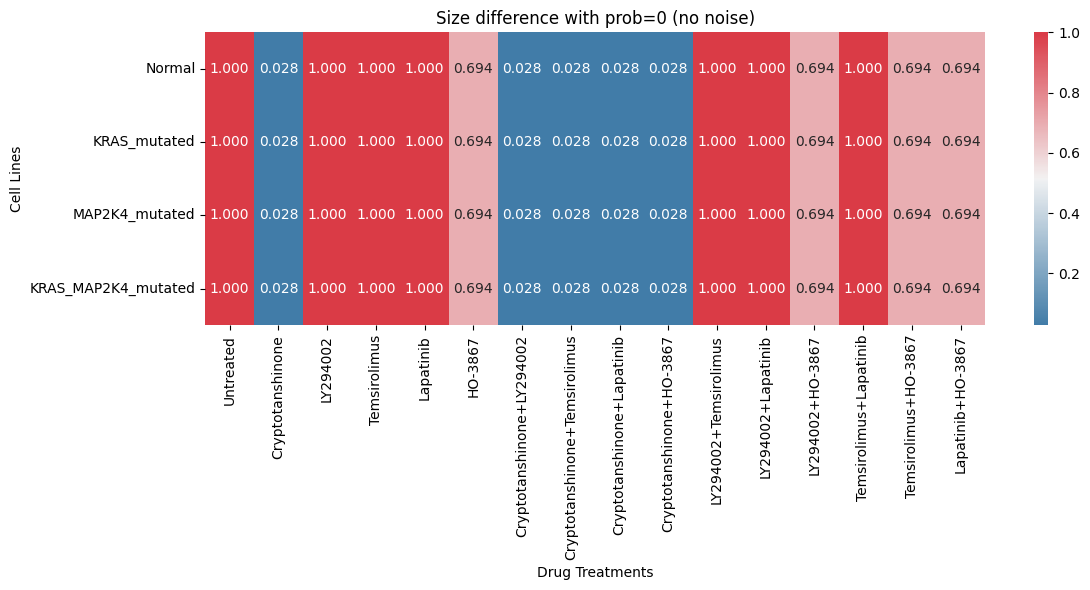

Running simulation with probability = 0.1
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


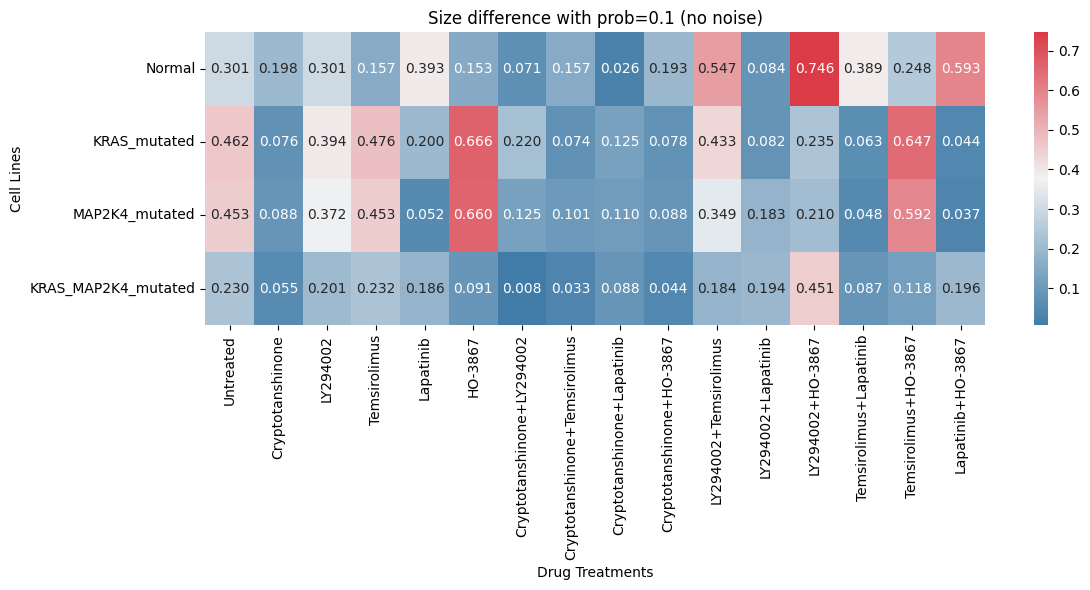

Running simulation with probability = 0.2
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


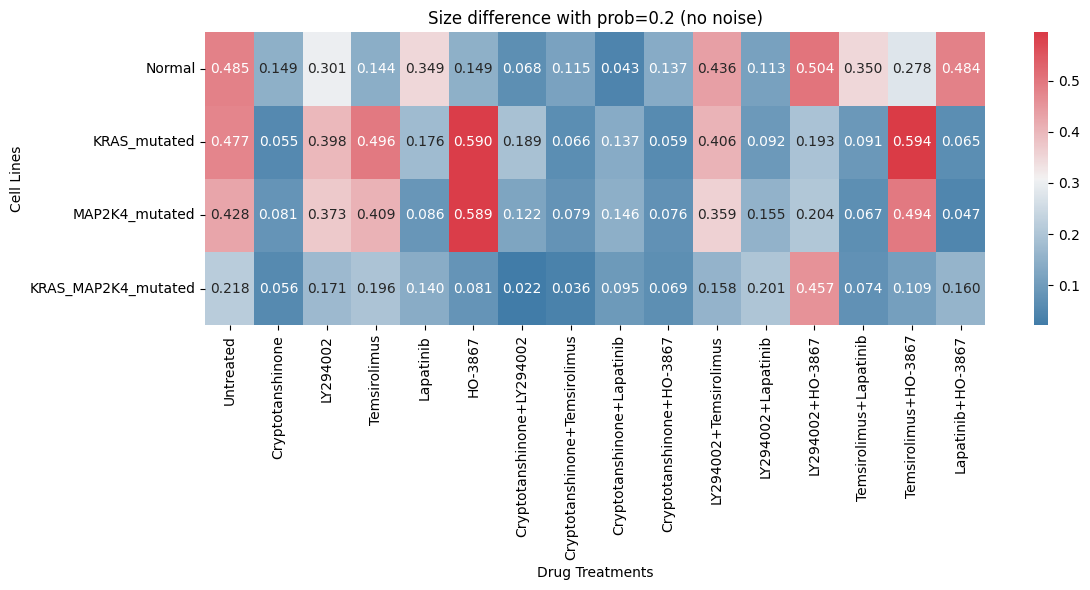

Running simulation with probability = 0.3
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


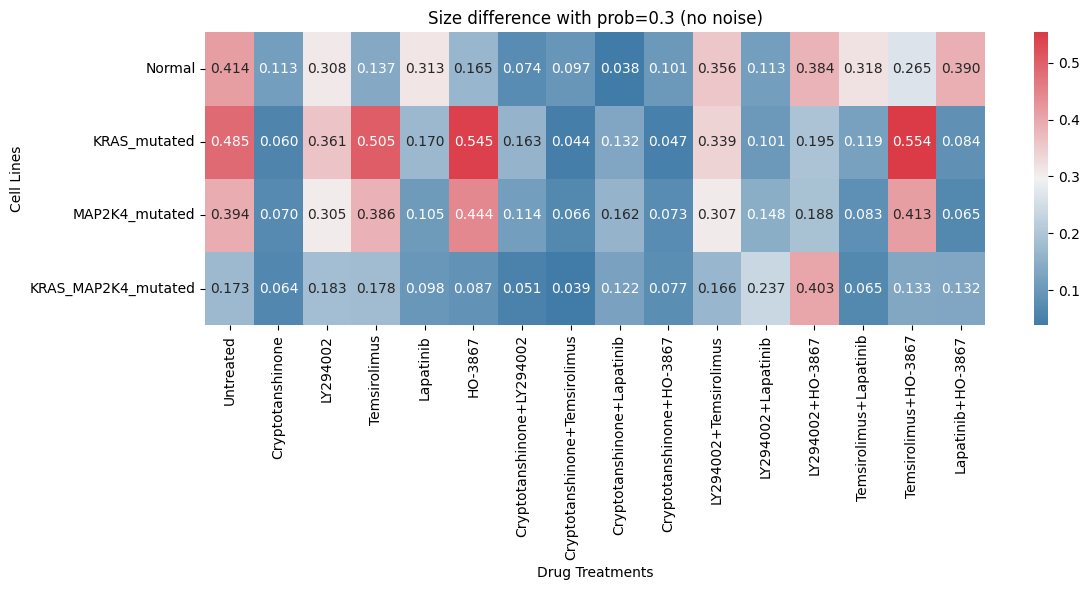

Running simulation with probability = 0.4
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


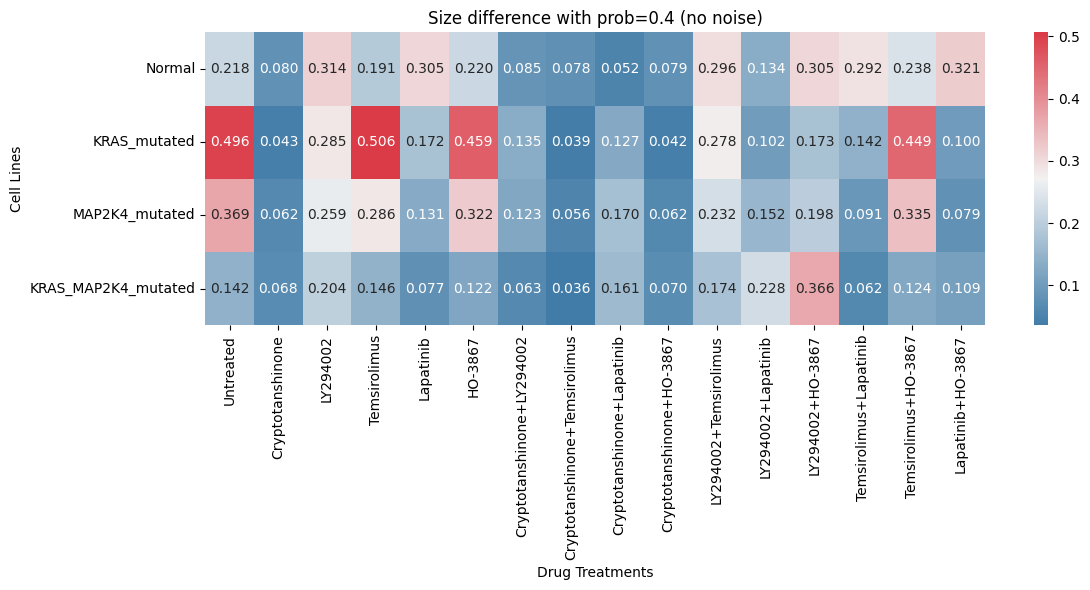

Running simulation with probability = 0.5
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


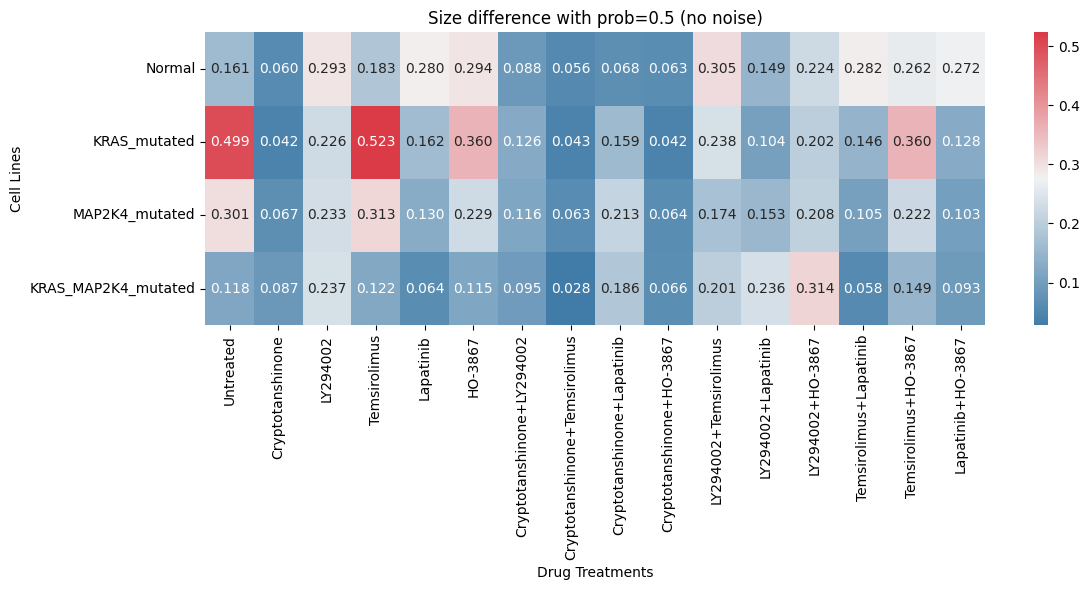

Running simulation with probability = 0.6
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


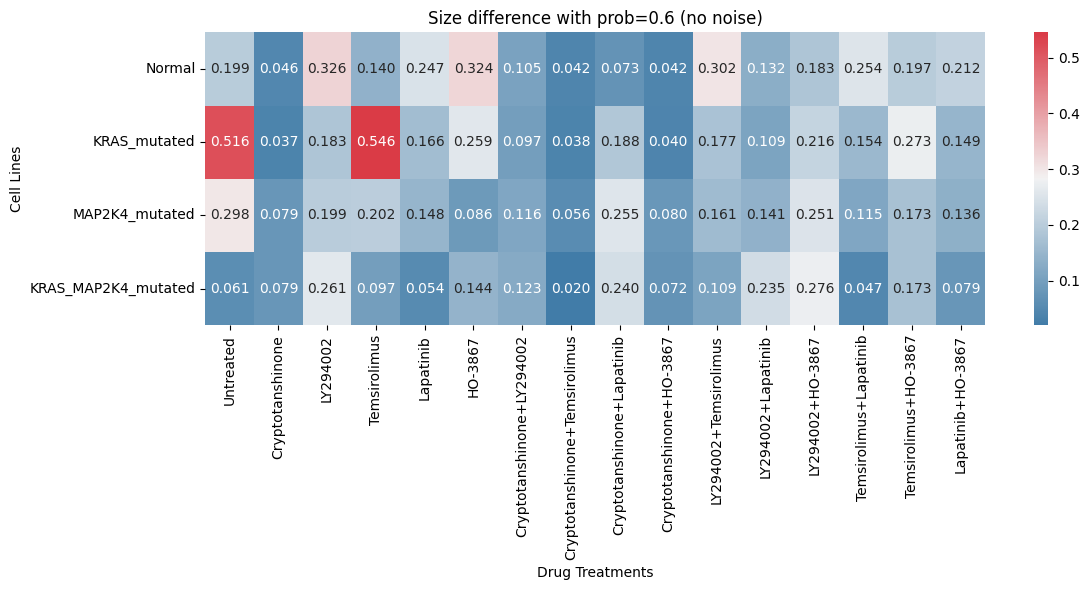

Running simulation with probability = 0.7
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


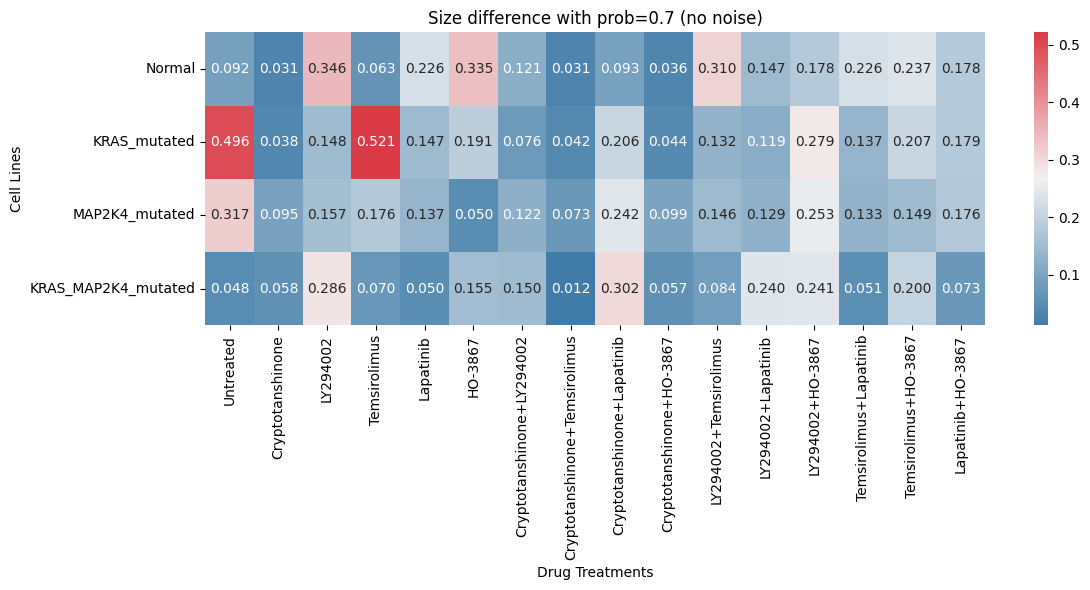

Running simulation with probability = 0.8
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


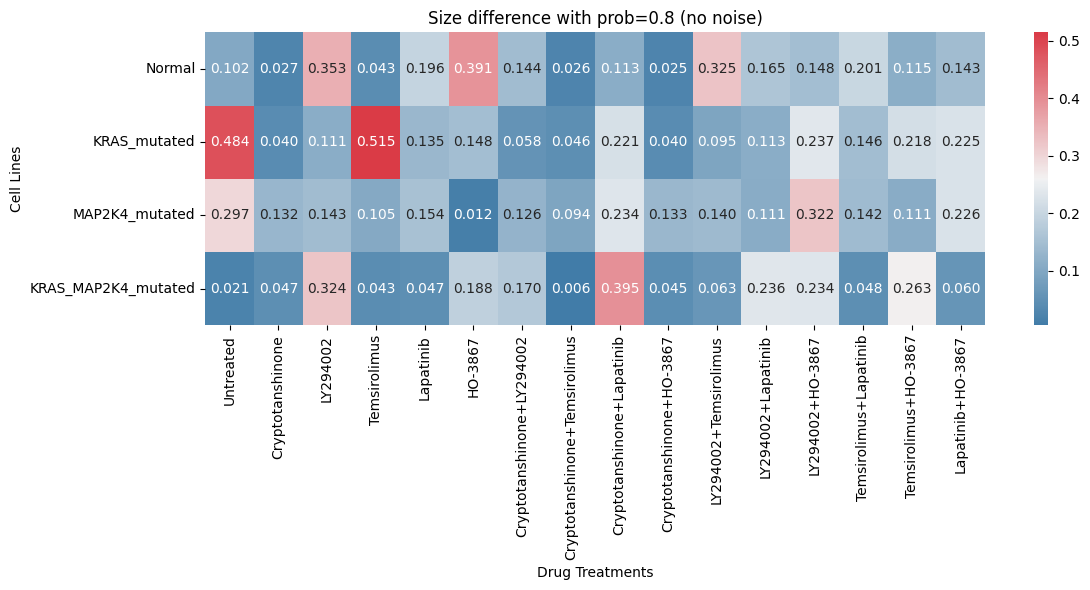

Running simulation with probability = 0.9
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


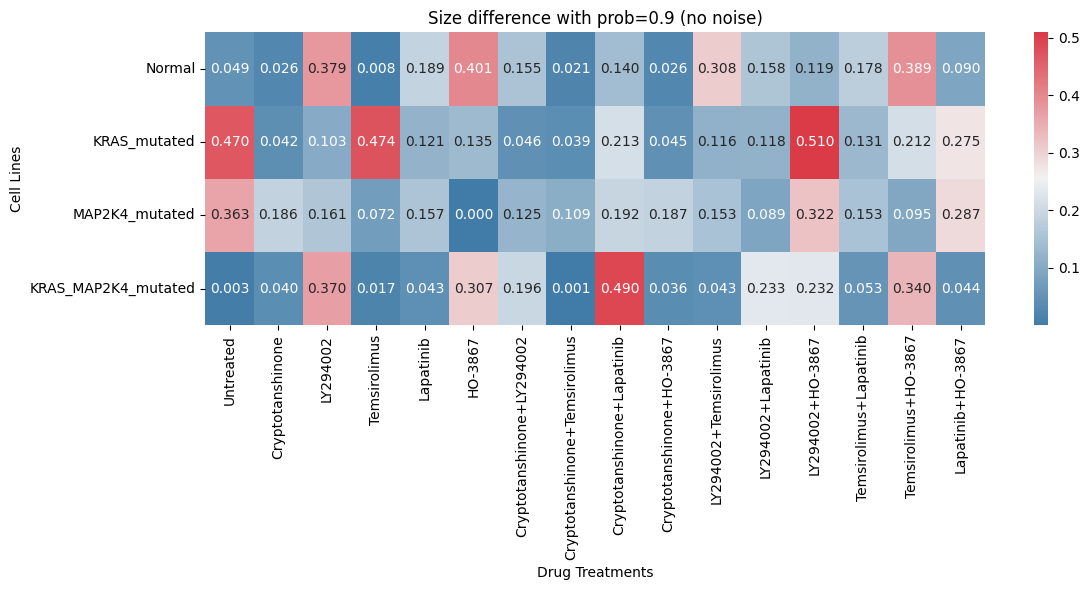

Running simulation with probability = 1
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


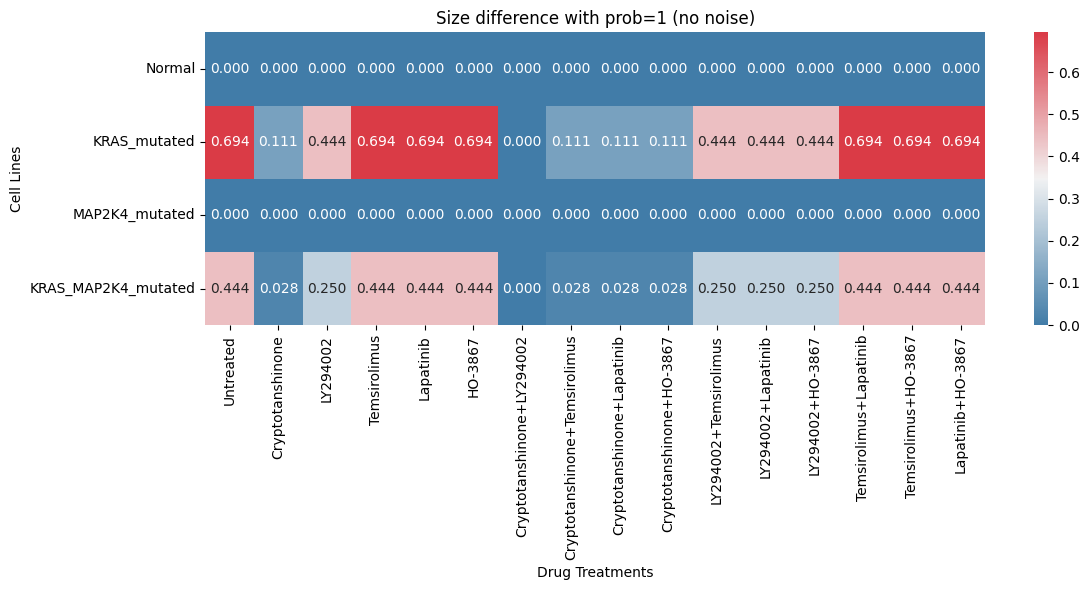

In [61]:
# Run sensitivity analysis for multiple probability values
prob_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sensitivity_results_no_noise = {}

for prob in prob_values:
    print(f"Running simulation with probability = {prob}")
    results = run_pbn_simulation(prob, noise=0, n_steps=1000)
    sensitivity_results_no_noise[prob] = results
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # Blue to red
    # vmin = 0.0  # Blue
    # vmax = 0.7  # Red
    # visualize each result individually
    plt.figure(figsize=(12, 6))
    sns.heatmap(results.astype(float), annot=True, cmap=cmap, fmt=".3f")
    plt.title(f"Size difference with prob={prob} (no noise)")
    plt.ylabel("Cell Lines")
    plt.xlabel("Drug Treatments")
    plt.tight_layout()
    plt.show()

In [62]:
# Save the results dictionary
with open('output/sensitivity_results_no_noise.pkl', 'wb') as f:
    pickle.dump(sensitivity_results_no_noise, f)

## With noise = 0.05, steps = 100000

Running simulation with probability = 0
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


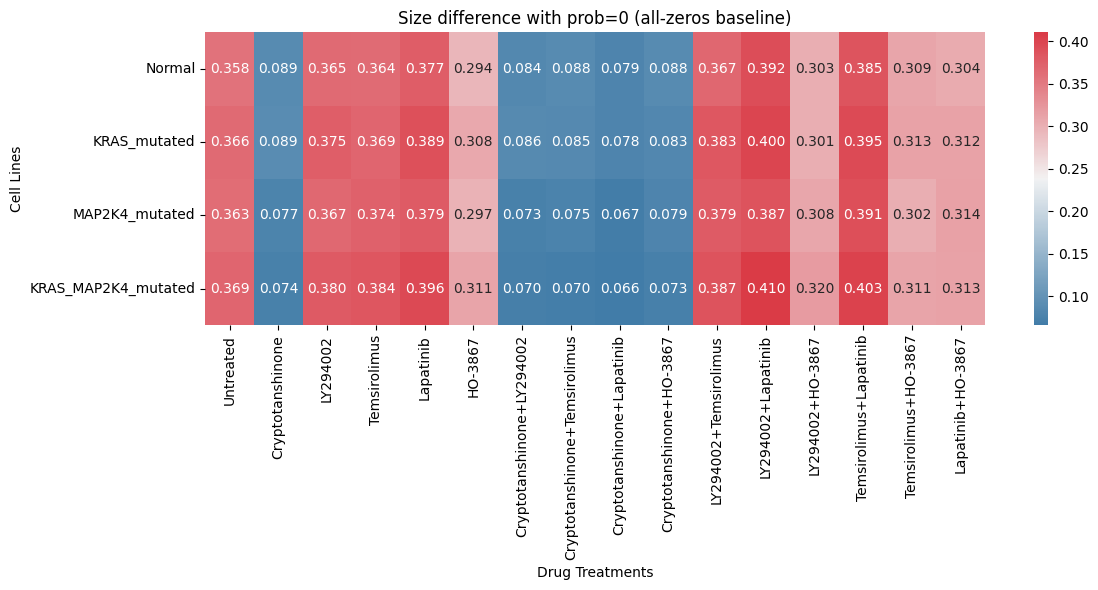

Running simulation with probability = 0.1
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


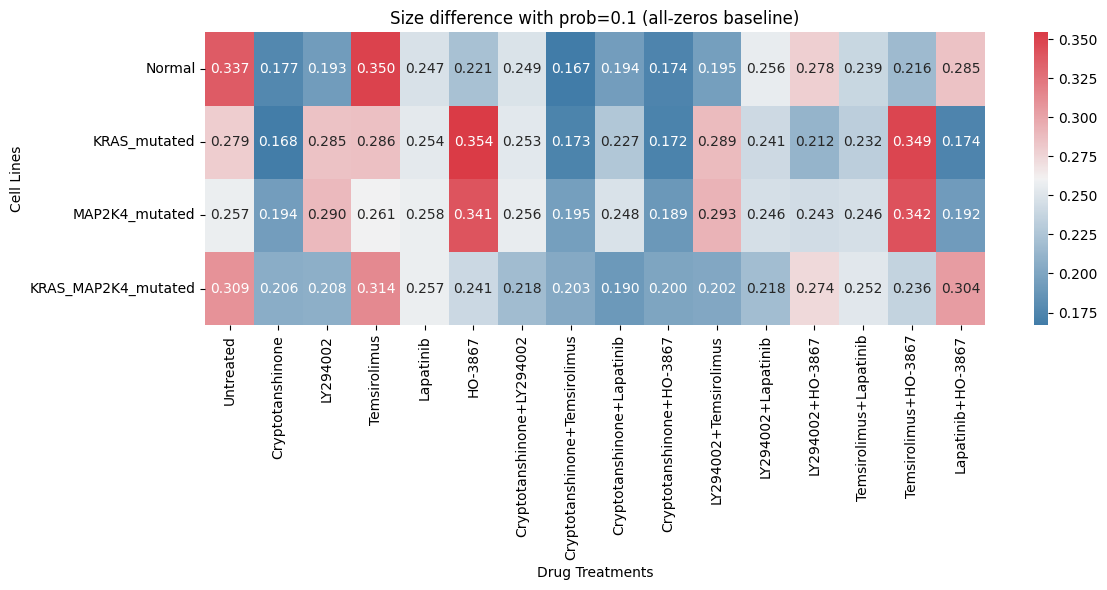

Running simulation with probability = 0.2
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


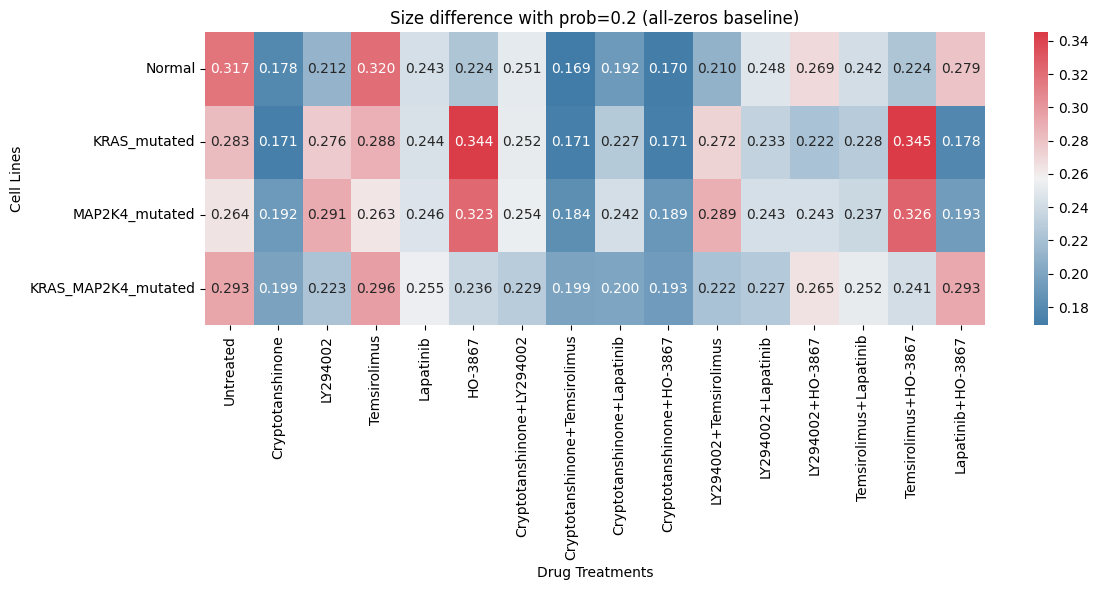

Running simulation with probability = 0.3
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


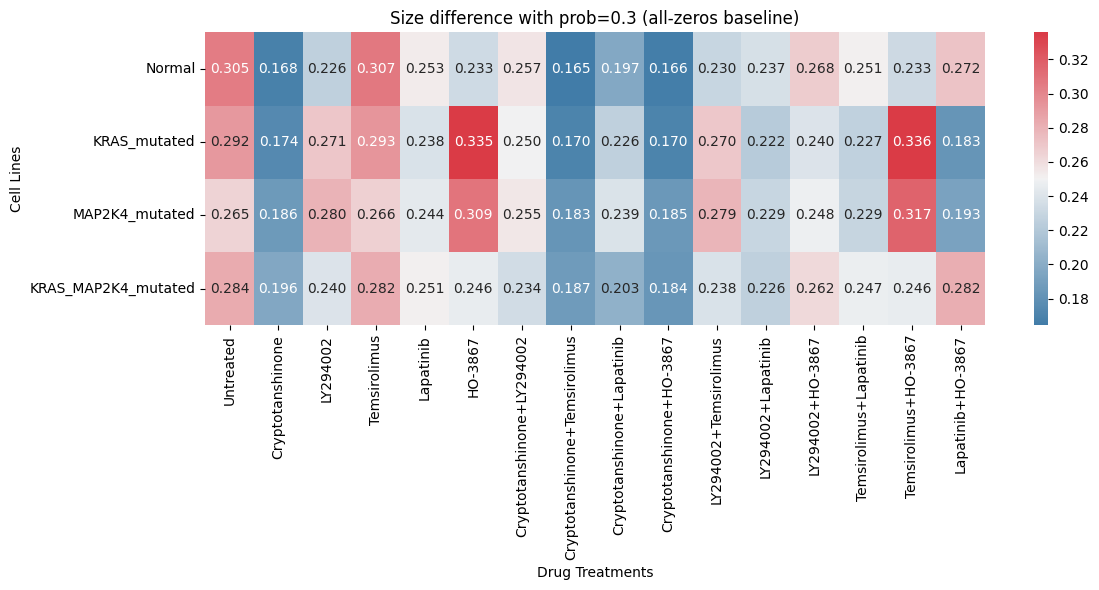

Running simulation with probability = 0.4
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


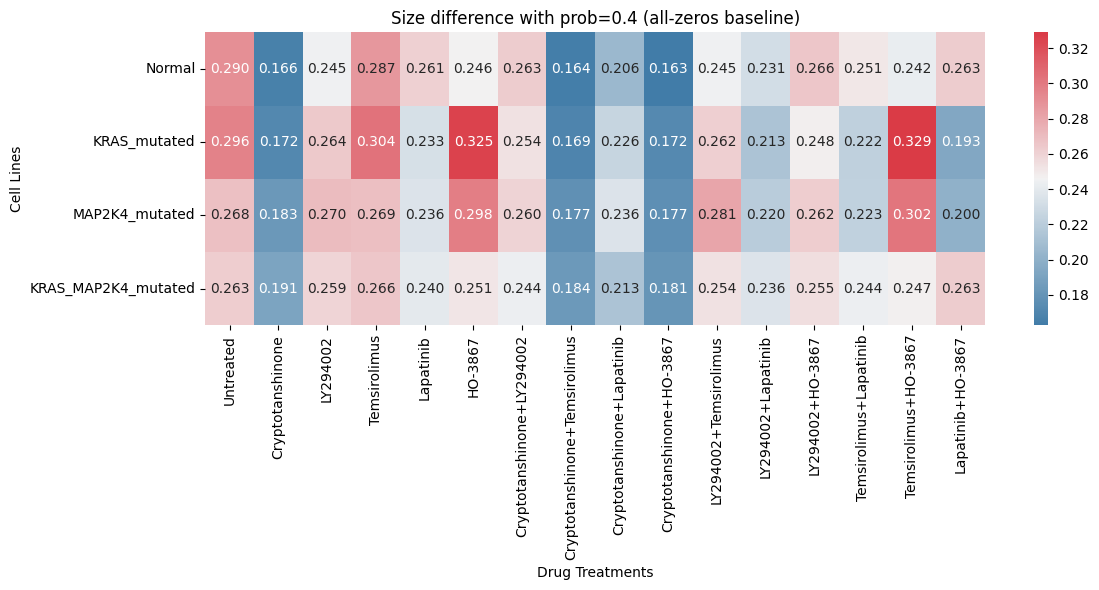

Running simulation with probability = 0.5
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


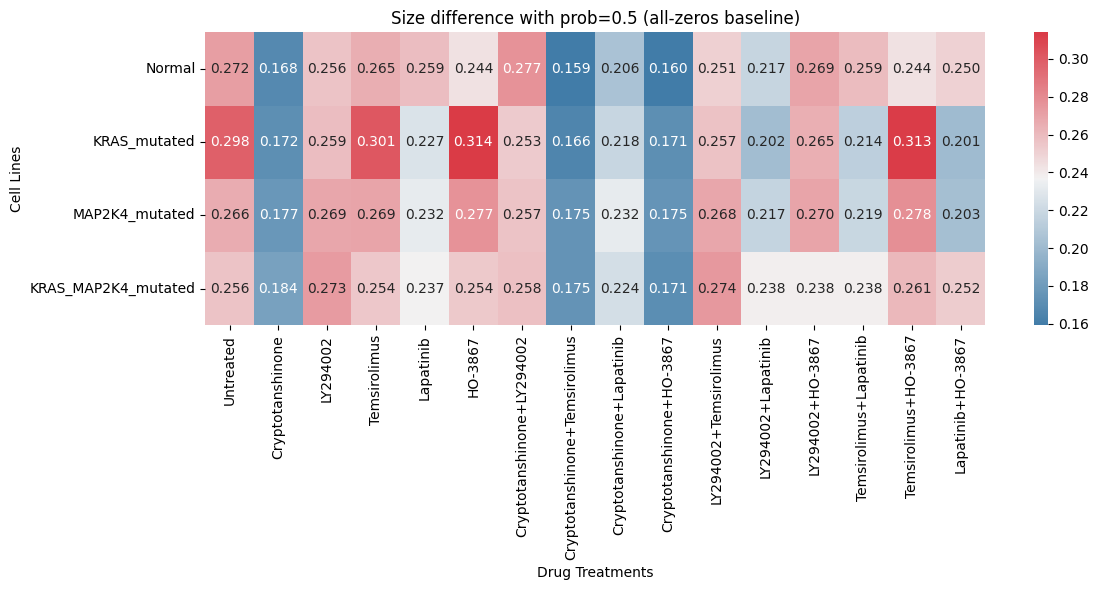

Running simulation with probability = 0.6
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


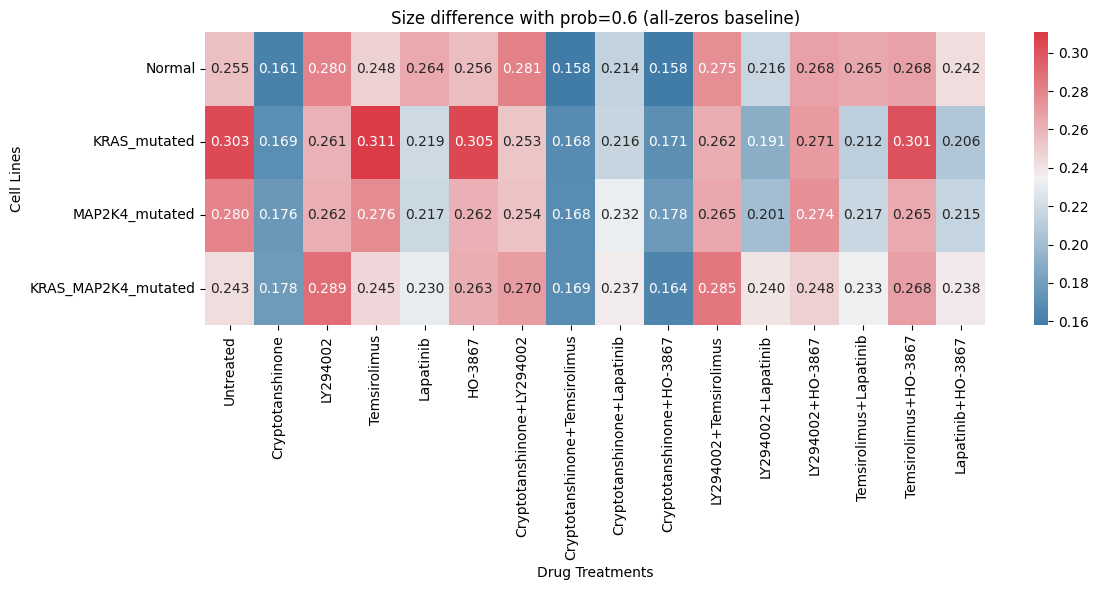

Running simulation with probability = 0.7
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


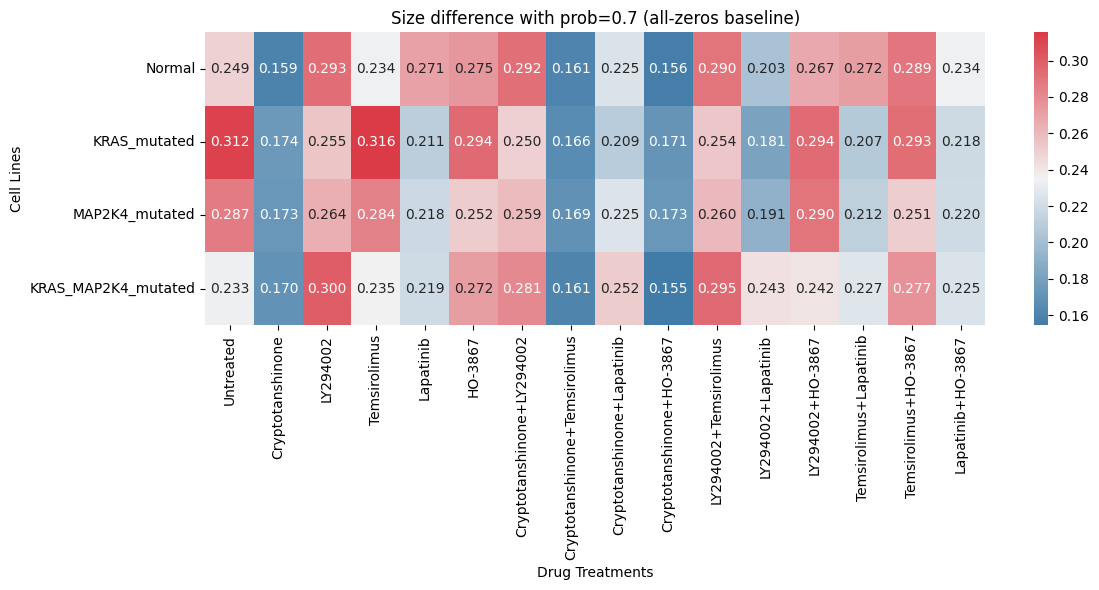

Running simulation with probability = 0.8
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


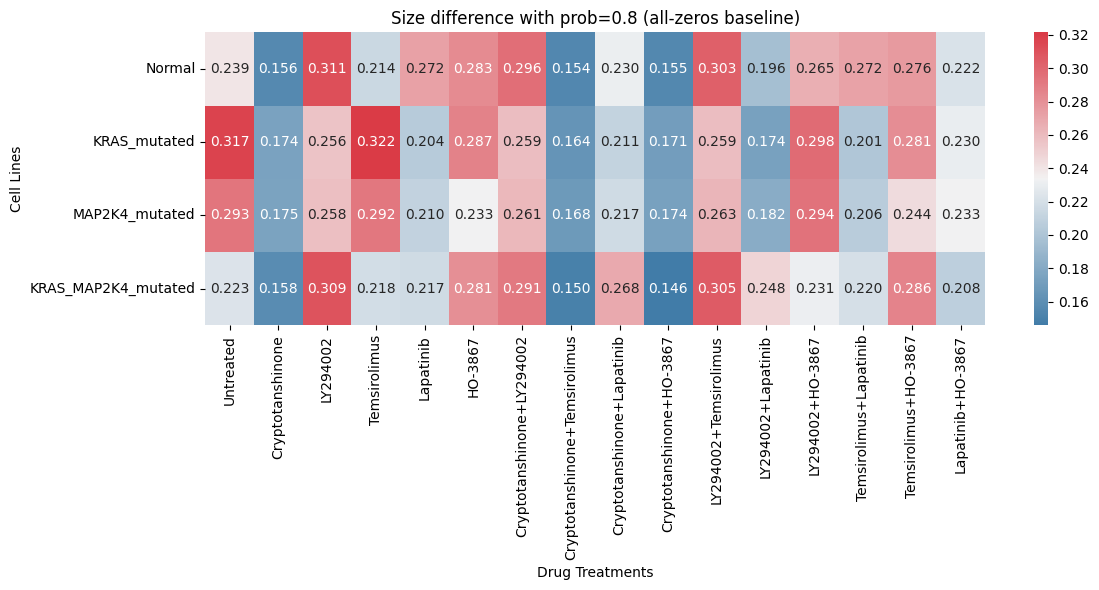

Running simulation with probability = 0.9
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


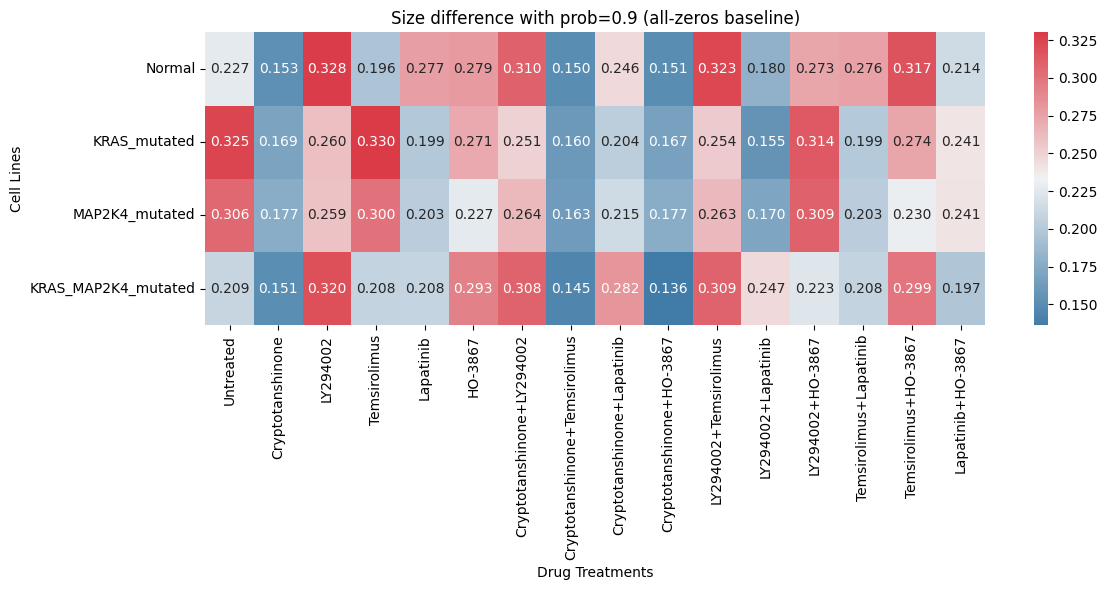

Running simulation with probability = 1
Only original model has this target: RHEB
Only original model has this target: SP1
Only KG model has this target: PCSK7
Only original model has this target: PIP3
No initial state provided, using a random initial state


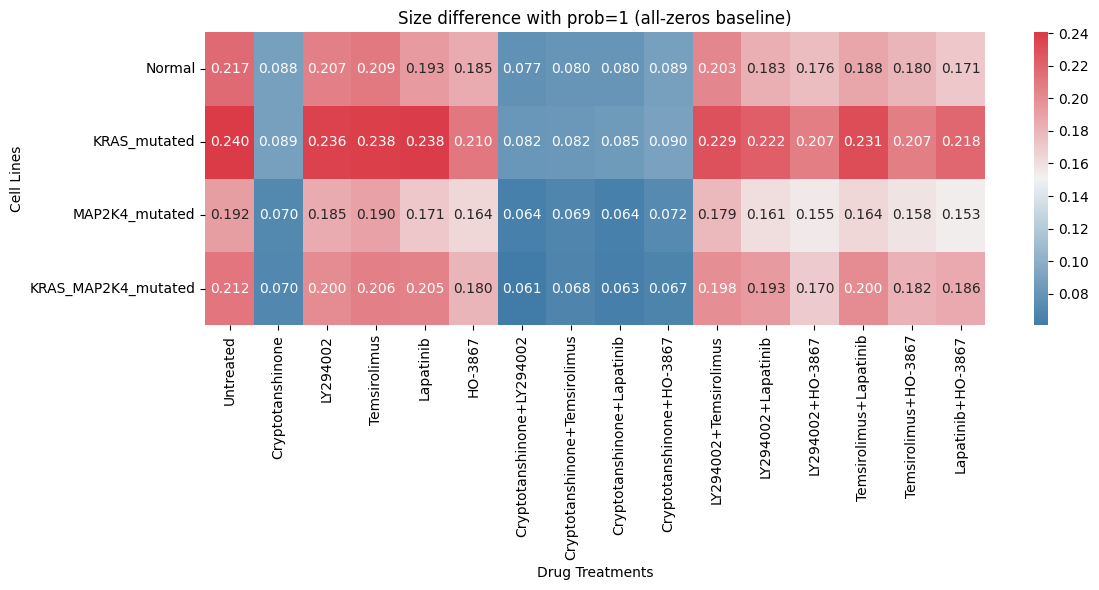

In [63]:
# Run sensitivity analysis for multiple probability values
prob_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sensitivity_results = {}

for prob in prob_values:
    print(f"Running simulation with probability = {prob}")
    results = run_pbn_simulation(prob)
    sensitivity_results[prob] = results
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # Blue to red

    # visualize each result individually
    plt.figure(figsize=(12, 6))
    sns.heatmap(results.astype(float), annot=True, cmap=cmap, fmt=".3f")
    plt.title(f"Size difference with prob={prob} (all-zeros baseline)")
    plt.ylabel("Cell Lines")
    plt.xlabel("Drug Treatments")
    plt.tight_layout()
    plt.show()

In [64]:
# Save the results dictionary
with open('output/sensitivity_results.pkl', 'wb') as f:
    pickle.dump(sensitivity_results, f)

In [10]:
# Load it back
with open('output/sensitivity_results.pkl', 'rb') as f:
    sensitivity_results = pickle.load(f)

## Mean outcome value


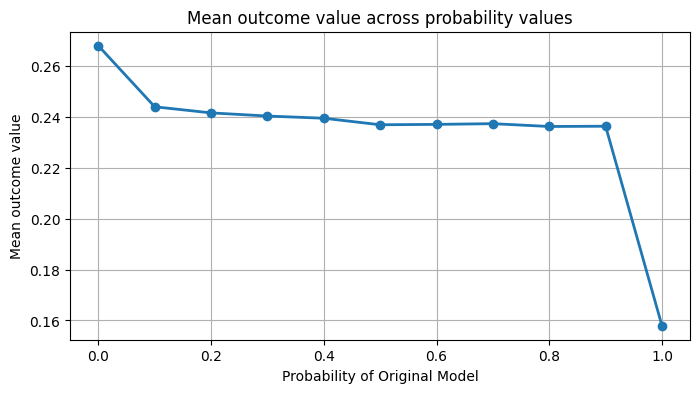

In [65]:
# Calculate sensitivity metrics
# mean size difference for each probability value
mean_differences = {}
for prob, results_df in sensitivity_results.items():
    mean_differences[prob] = results_df.values.mean()

# Plot how mean size difference changes with probability
plt.figure(figsize=(8, 4))
plt.plot(list(mean_differences.keys()), list(mean_differences.values()), 'o-', linewidth=2)
plt.xlabel('Probability of Original Model')
plt.ylabel('Mean outcome value')
plt.title('Mean outcome value across probability values')
plt.grid(True)
plt.show()

## Variance across probability values

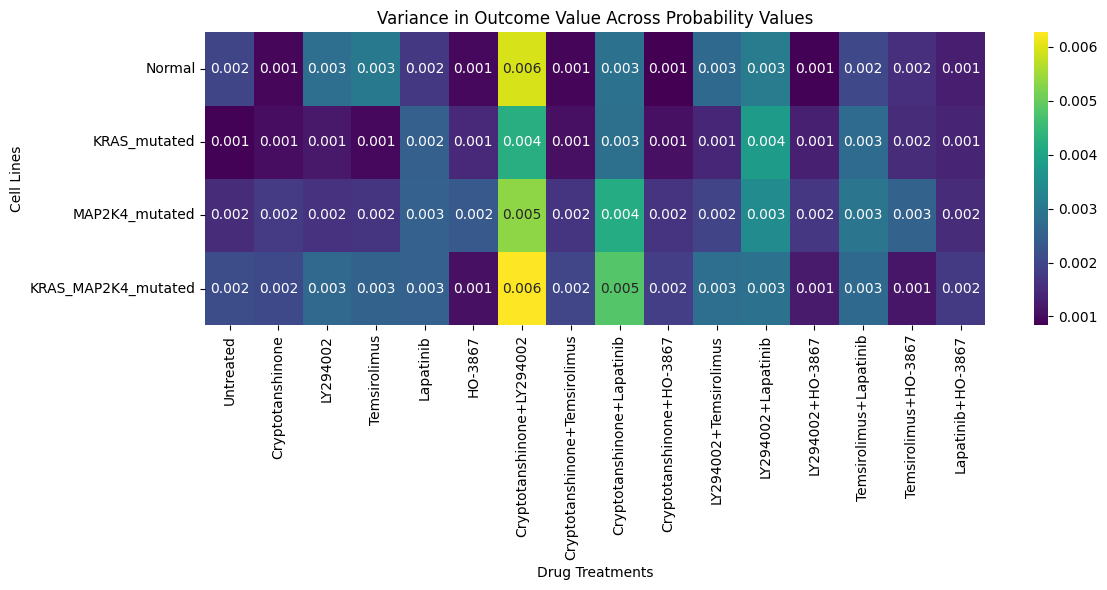

In [66]:
variance_df = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)

for cell_line in cell_profiles.keys():
    for treatment in all_treatments:
        # Get values for this cell-treatment combo across all probabilities
        values = [df.loc[cell_line, treatment] for df in sensitivity_results.values()]
        variance_df.loc[cell_line, treatment] = np.var(values)

# Visualize variance with heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(variance_df.astype(float), annot=True, cmap="viridis", fmt=".3f")
plt.title("Variance in Outcome Value Across Probability Values")
plt.ylabel("Cell Lines")
plt.xlabel("Drug Treatments")
plt.tight_layout()
plt.show()

# Target-specific sensitivity

Perform a more detailed sensitivity analysis to evaluate the impact of changing the probability for individual equations rather than using the same probability value for all equations.

In [67]:
def merge_PBN_string_individual_probs(original_string, KG_string, prob_dict=None, default_prob=0.5):
    """
    Merge the original model and the KG model to a PBN with individual probabilities
    
    Args:
        original_string: String representation of original model
        KG_string: String representation of KG model
        prob_dict: Dictionary mapping gene names to probabilities for the original model
        default_prob: Default probability to use for genes not in prob_dict
    
    Returns:
        Merged PBN string with individualized probabilities
    """
    if prob_dict is None:
        prob_dict = {}
    
    # Parse equations from both models
    original_equations = {}
    for line in original_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            original_equations[target.strip()] = rule.strip()
    
    kg_equations = {}
    for line in KG_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            kg_equations[target.strip()] = rule.strip()
    
    # Merge equations
    merged_equations = []
    all_targets = set(original_equations.keys()) | set(kg_equations.keys())
        
    for target in all_targets:
        # Get the probability for this target (use default if not specified)
        target_prob = prob_dict.get(target, default_prob)
        
        if target in original_equations and target in kg_equations:
            if original_equations[target] == kg_equations[target]:
                # Both models have the same equation for this target
                merged_equations.append(f"{target} = {original_equations[target]}, 1")
            else:
                # Use both with specified probabilities
                merged_equations.append(f"{target} = {original_equations[target]}, {target_prob}")
                merged_equations.append(f"{target} = {kg_equations[target]}, {1-target_prob}")
        elif target in original_equations:
            # Only original model has this target
            merged_equations.append(f"{target} = {original_equations[target]}, 1")
        else:
            # Only KG model has this target
            merged_equations.append(f"{target} = {kg_equations[target]}, 1")
    
    # remove equation with prob = 0
    merged_equations = [eq for eq in merged_equations if eq.split(',')[1] != ' 0']
    merged_string = '\n'.join(merged_equations)
    return merged_string

def run_pbn_simulation_with_pbn(pbn, noise=0.05, n_steps=50000):
    """
    Run PBN simulation with a pre-loaded PBN object.
    """
    # Initialize results dataframe
    df_results = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)
    
    # Process each cell line
    for cell_line, mutation_profile in cell_profiles.items():
        mutations = mutation_profile.split(',') if mutation_profile else []
        
        # Process each drug treatment
        for drug in drugs:
            pbn.undoKnockouts()
            pbn.setInitialValue('PTEN', 1)
            pbn.setInitialValue('STK11', 1)
            pbn.setInitialValue('EGF', 0)
            pbn.setInitialValue('HBEGF', 0)
            pbn.setInitialValue('IGF1', 0)
            pbn.setInitialValue('NRG1', 0)
            
            # Apply mutations based on cell line 
            for gene in mutations:
                if gene.strip(): 
                    pbn.knockout(gene, mutations_dict[gene])
           
            # Apply drug effects
            for ko_gene in drug_knockouts[drug]:
                pbn.knockout(ko_gene, 0)
            
            # Run simulation
            results = pbn.update_noise(noise, n_steps) 
            cal_range = results[n_steps//2:n_steps]
            average_array = np.mean(cal_range, axis=0)
            output_values = [average_array[pbn.nodeDict[k]] for k in output_genes]
            
            # Calculate size difference against all-zeros baseline
            size_diff = calculate_size_difference_bi(output_values)
            df_results.loc[cell_line, drug] = size_diff
        
        # Process each double drug combination
        for d1, d2 in double_drugs:
            combo_name = f"{d1}+{d2}"
            
            pbn.undoKnockouts()
            pbn.setInitialValue('PTEN', 1)
            pbn.setInitialValue('STK11', 1)
            pbn.setInitialValue('EGF', 0)
            pbn.setInitialValue('HBEGF', 0)
            pbn.setInitialValue('IGF1', 0)
            pbn.setInitialValue('NRG1', 0)
            
            # Apply mutations
            for gene in mutations:
                if gene.strip():
                    pbn.knockout(gene, mutations_dict[gene])
            
            # Apply combined drug effects
            for ko_gene in drug_knockouts[d1] + drug_knockouts[d2]:
                pbn.knockout(ko_gene, 0)
            
            # Run simulation
            pbn_traj = pbn.update_noise(noise, n_steps)
            cal_range = pbn_traj[n_steps//2:n_steps]
            average_array = np.mean(cal_range, axis=0)
            output_values = [average_array[pbn.nodeDict[k]] for k in output_genes]
            
            # Calculate size difference
            size_diff = calculate_size_difference_bi(output_values)
            df_results.loc[cell_line, combo_name] = size_diff
    
    return df_results

def run_individual_sensitivity_analysis(default_prob = 1, test_prob_values = [0.0, 0.25, 0.5, 0.75]):
    """
    Run sensitivity analysis by varying the probability of each individual equation.
    test_prob_values is a list of probability values to test.
    default_prob is the probability value to use for the base case.
    """
    # Get all targets that have different equations in both models
    original_equations = {}
    for line in original_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            original_equations[target.strip()] = rule.strip()
    
    kg_equations = {}
    for line in KG_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            kg_equations[target.strip()] = rule.strip()
    
    differing_targets = []
    for target in set(original_equations.keys()) & set(kg_equations.keys()):
        if original_equations[target] != kg_equations[target]:
            differing_targets.append(target)
    
    print(f"Found {len(differing_targets)} targets with different equations in both models")
    
    # Base case - all equations use default probability
    base_prob_dict = {target: default_prob for target in differing_targets}
    
    # Run base simulation
    base_merged_string = merge_PBN_string_individual_probs(original_string, KG_string, base_prob_dict)
    print(base_merged_string)
    base_pbn = BMatrix.load_pbn_from_string(base_merged_string)
    base_results = run_pbn_simulation_with_pbn(base_pbn)
    
    # Test each target individually
    sensitivity_by_target = {}
    
    for target in differing_targets:
        target_sensitivity = {}
        
        for test_prob in test_prob_values:
            # Make a copy of the base probability dictionary
            test_prob_dict = base_prob_dict.copy()
            # Change only the probability for the current target
            test_prob_dict[target] = test_prob
            
            print(f"Testing {target} with probability {test_prob}")
            test_merged_string = merge_PBN_string_individual_probs(original_string, KG_string, test_prob_dict)
            test_pbn = BMatrix.load_pbn_from_string(test_merged_string)
            test_results = run_pbn_simulation_with_pbn(test_pbn)
            
            # Calculate difference from base case
            diff_results = (test_results - base_results).abs()
            
            # Store mean and max difference
            target_sensitivity[test_prob] = {
                'mean_diff': diff_results.values.mean(),
                'max_diff': diff_results.values.max(),
                'results': test_results,
                'diff_results': diff_results
            }
        
        sensitivity_by_target[target] = target_sensitivity
    
    return sensitivity_by_target, differing_targets, base_results

In [72]:
sensitivity_results_by_target, differing_targets, base_results = run_individual_sensitivity_analysis(test_prob_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])


Found 29 targets with different equations in both models
ERBB2 = NRG1, 1
STK11 = STK11, 1
PTEN = PTEN, 1
NRG1 = NRG1, 1
PIK3CA = (ERBB2 | IRS1) | (KRAS | STAT3), 1
PRKAA1 = STK11, 1
IGF1R = IGF1, 1
AKT1 = PIP3, 1
GSK3B = ! AKT1, 1
EGFR = EGF, 1
TSC1 = PRKAA1 | ( ! AKT1), 1
GRB2 = (ERBB2 | IGF1R) | (ERBB4 | EGFR), 1
ELK4 = RPS6KB1 & MAPK3, 1
RHEB = ! TSC1, 1
SP1 = MAPK3, 1
EGF = EGF, 1
MAPK3 = MAP2K1, 1
MAP2K4 = MAP3K1, 1
MAPK8 = MAP2K4, 1
PDPK1 = PIP3, 1
MAP3K1 = KRAS, 1
BAD = ! (AKT1 | RPS6KB1), 1
HBEGF = HBEGF, 1
JAK1 = EGFR, 1
KRAS = GRB2, 1
IGF1 = IGF1, 1
RAF1 = KRAS, 1
CCND1 = ! GSK3B, 1
ERBB4 = HBEGF | EGF, 1
ELK1 = RPS6KB1 & MAPK3, 1
FOS = RPS6KB1 & MAPK8, 1
PCSK7 = PCSK7, 1
RPS6KB1 = MTOR | (PDPK1 | MAPK3), 1
STAT3 = JAK1, 1
MAP2K1 = RAF1, 1
BCL2 = ( ! BAD & STAT3), 1
MTOR = RHEB, 1
PIP3 = ! PTEN | PIK3CA, 1
IRS1 = IGF1R, 1
No initial state provided, using a random initial state
Testing ERBB2 with probability 0.0
No initial state provided, using a random initial state
Testing E

In [89]:
# Save the results dictionary
with open('output/sensitivity_results_by_target.pkl', 'wb') as f:
    pickle.dump(sensitivity_results_by_target, f)

In [ ]:
# Load the results dictionary
with open('output/sensitivity_results_by_target.pkl', 'rb') as f:
    sensitivity_results_by_target = pickle.load(f)


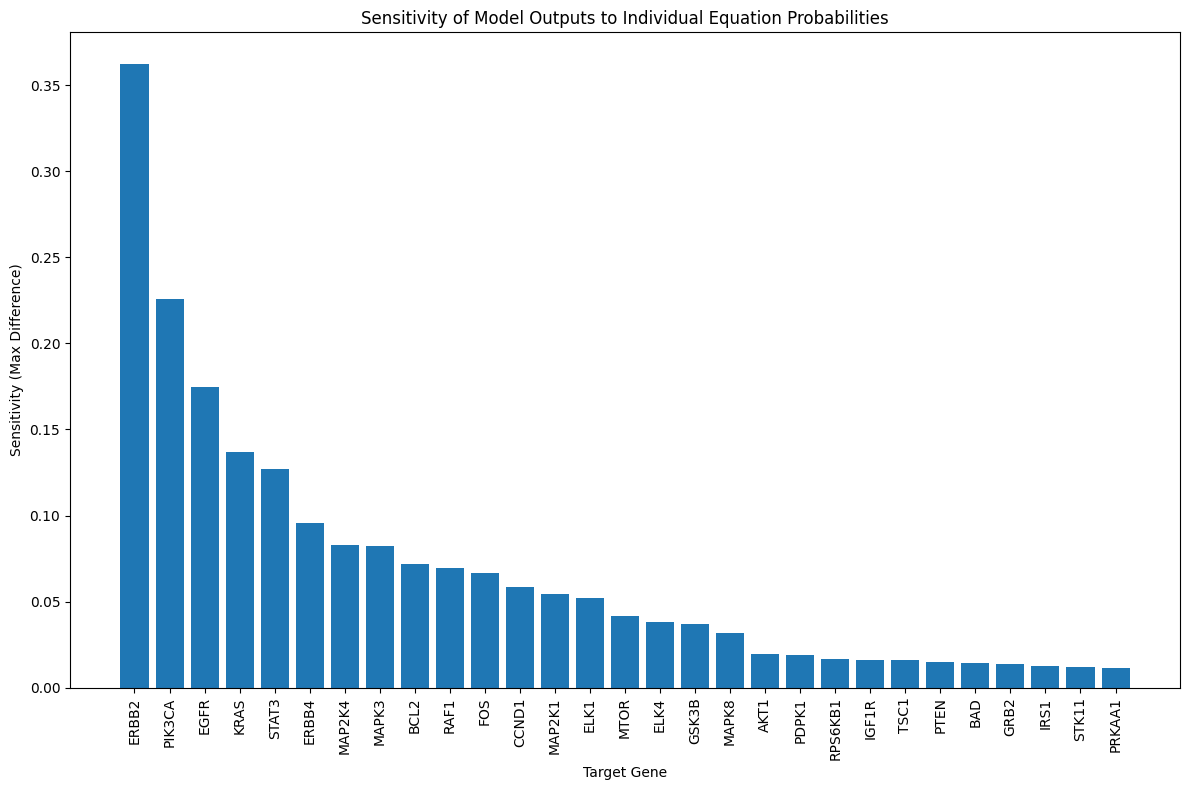

In [75]:
sensitivity_scores = {}
for target in differing_targets:
    # Maximum difference observed for any test probability
    max_sensitivity = max([data['max_diff'] for prob, data in sensitivity_results_by_target[target].items()])
    sensitivity_scores[target] = max_sensitivity

# Create a bar chart of target sensitivities
plt.figure(figsize=(12, 8))
targets_sorted = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)
x = [item[0] for item in targets_sorted]
y = [item[1] for item in targets_sorted]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.xlabel('Target Gene')
plt.ylabel('Sensitivity (Max Difference)')
plt.title('Sensitivity of Model Outputs to Individual Equation Probabilities')
plt.tight_layout()
plt.show()

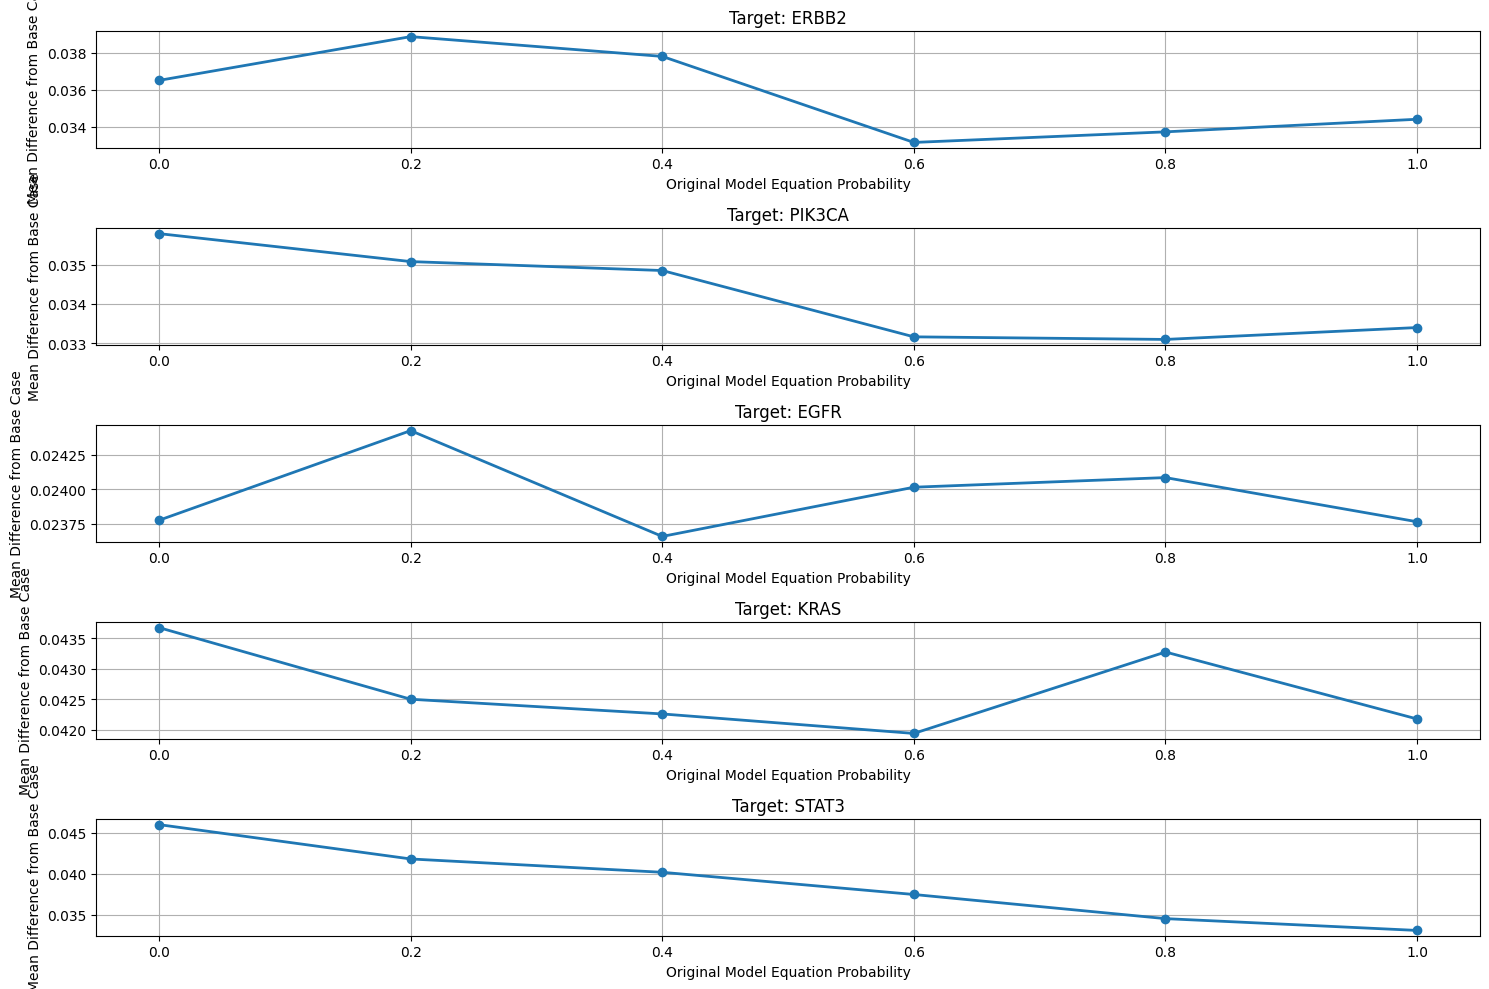

In [79]:
# visualization for the most sensitive targets
top_targets = x[:5]  # Take the top 5 most sensitive targets
plt.figure(figsize=(15, 10))
for i, target in enumerate(top_targets):
    plt.subplot(len(top_targets), 1, i+1)
    
    # Get the test probability values used
    prob_values = sorted(sensitivity_results_by_target[target].keys())
    
    # Plot mean difference for each probability value
    mean_diffs = [sensitivity_results_by_target[target][p]['mean_diff'] for p in prob_values]
    plt.plot(prob_values, mean_diffs, 'o-', linewidth=2)
    
    plt.title(f'Target: {target}')
    plt.xlabel('Original Model Equation Probability')
    plt.ylabel('Mean Difference from Base Case')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

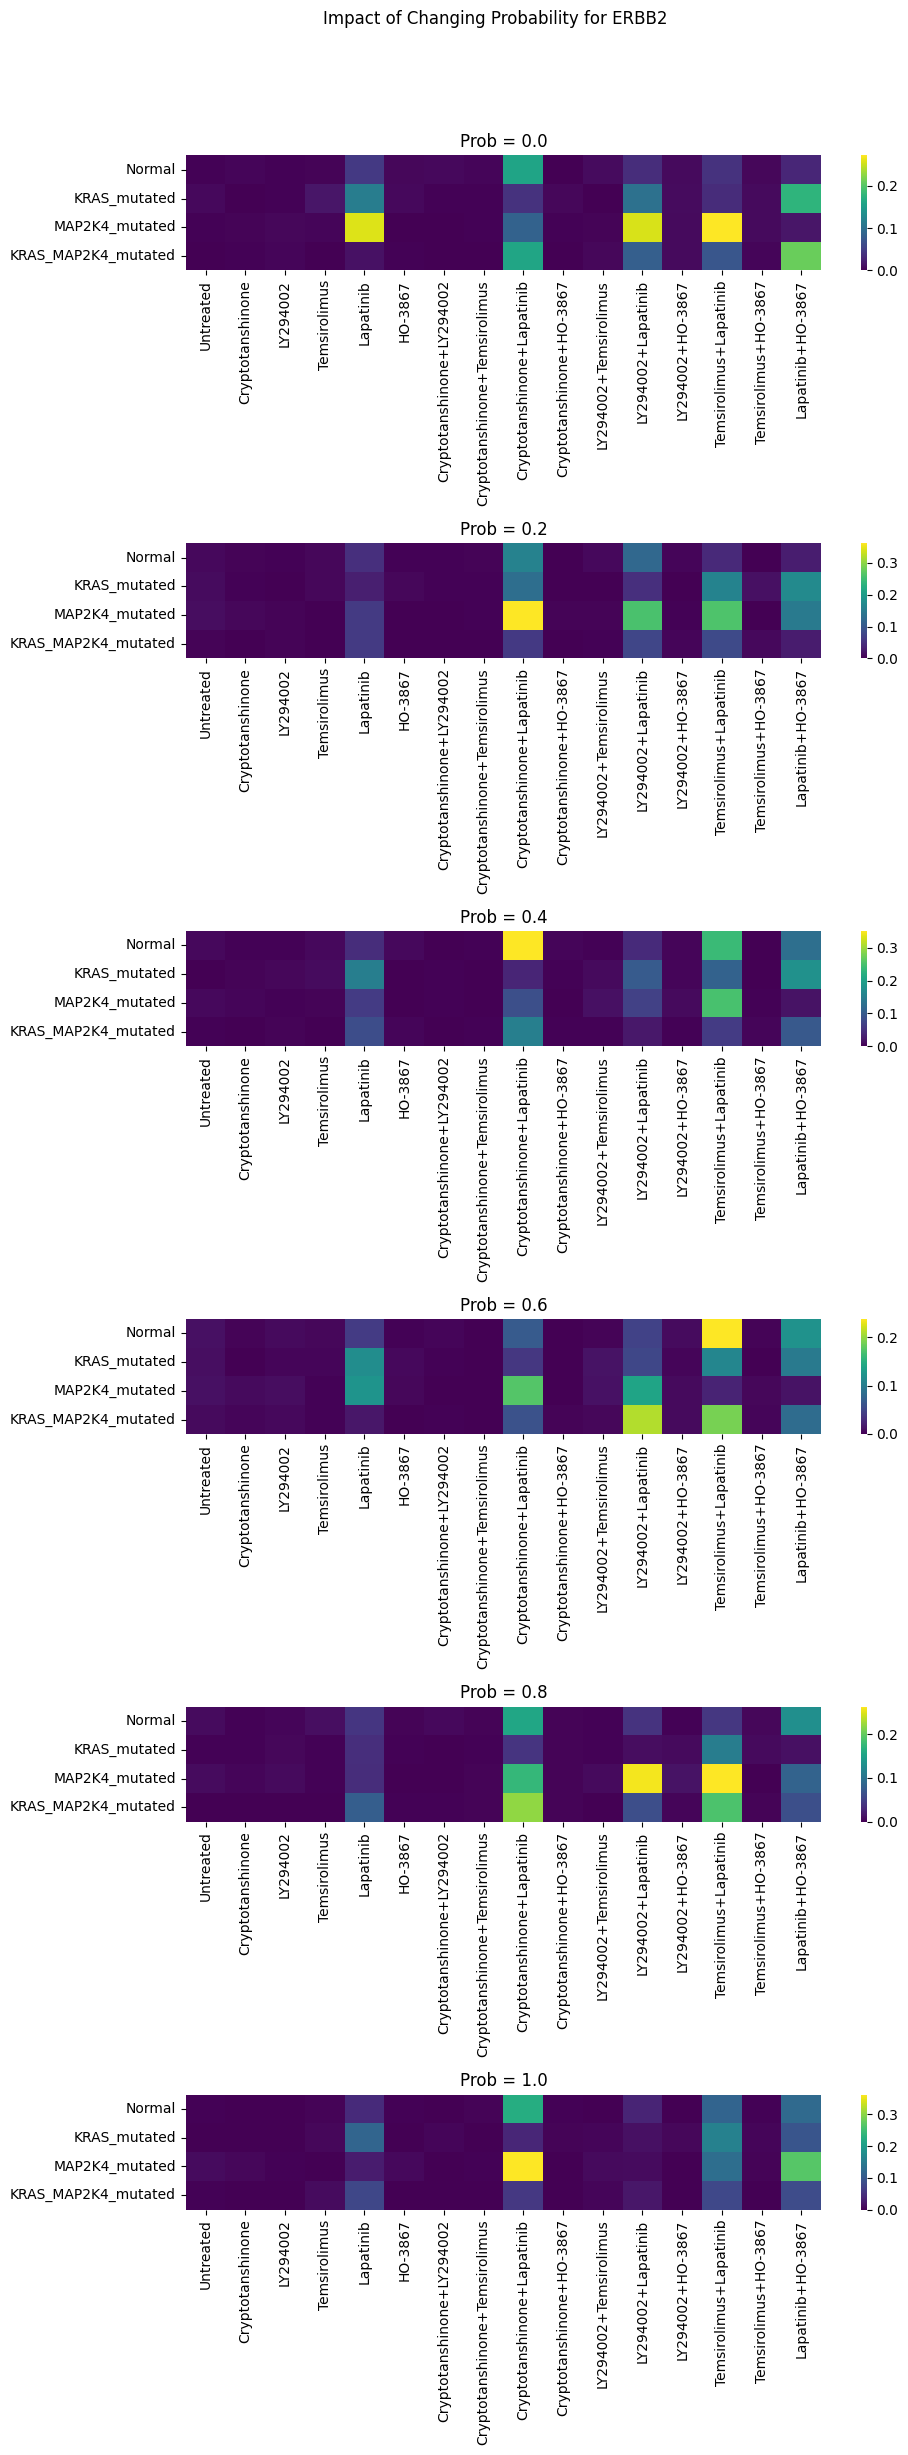

In [86]:
# heatmaps for the most sensitive target
most_sensitive_target = targets_sorted[0][0]
# Plot difference heatmaps for various probability values
fig, axes = plt.subplots(len(sensitivity_results_by_target[most_sensitive_target]), 1,
                         figsize=(10, 25), sharey=True)
for i, prob in enumerate(sorted(sensitivity_results_by_target[most_sensitive_target].keys())):
    data = sensitivity_results_by_target[most_sensitive_target][prob]['diff_results'].astype(float)
    sns.heatmap(data, ax=axes[i], cmap='viridis', 
                vmin=0, vmax=data.values.max())
    axes[i].set_title(f'Prob = {prob}')
    if i > 0:
        axes[i].set_ylabel('')
plt.suptitle(f'Impact of Changing Probability for {most_sensitive_target}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()